In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import scprep
import phate
import igraph
import seaborn as sns

# pairwise distance
def compute_distances(X):
    '''
    Constructs a distance matrix from data set, assumes Euclidean distance

    Inputs:
        X       a numpy array of size n x p holding the data set (n observations, p features)

    Outputs:
        D       a numpy array of size n x n containing the euclidean distances between points

    '''
    
    # return distance matrix
    D = np.linalg.norm(X[:,:, np.newaxis] - X[:,:, np.newaxis].T, axis = 1)
    
    return D


def compute_affinity_matrix(D, kernel_type, sigma=None, k=None):
    '''
    Construct an affinity matrix from a distance matrix via gaussian kernel.

    Inputs:
        D               a numpy array of size n x n containing the distances between points
        kernel_type     a string, either "gaussian" or "adaptive".
                            If kernel_type = "gaussian", then sigma must be a positive number
                            If kernel_type = "adaptive", then k must be a positive integer
        sigma           the non-adaptive gaussian kernel parameter
        k               the adaptive kernel parameter

    Outputs:
        W       a numpy array of size n x n that is the affinity matrix

    '''

    # return the affinity matrix
    if kernel_type == "gaussian":
        if sigma is None:
            raise ValueError('sigma must be provided for gaussian kernel.')
        elif ((type(sigma) is not int) and (type(sigma) is not float)) or sigma <= 0:
            raise ValueError('sigma must be a positive number.')
            
        W = np.exp(- D ** 2 / (2 * sigma ** 2)) 
        
    elif kernel_type == "adaptive":
        if k is None:
            raise ValueError('k must be provided for adaptive gaussian kernel.')
        elif (type(k) is not int) or k <= 0:
            raise ValueError('k must be a positive integer.')
        # compute sigma 
        D_copy = D.copy()
        D_copy = D + np.diag(np.repeat(float("inf"), D.shape[0]))
        nn = D_copy.argsort(axis = 1)

        kth_idx = nn[:,k-1]
        kth_dist = D[range(D.shape[0]), kth_idx]
        s_i = np.tile(kth_dist[:,np.newaxis], (1, D.shape[0]))
        W = 1 / 2 * (np.exp(- D ** 2 / (s_i**2)) + np.exp(- D ** 2 / (s_i.transpose()**2)))

    else:
        raise ValueError('kernel_type must be either "gaussian" or "adaptive".')
        
    return W

In [146]:
data = pd.read_csv("~/scratch60/single_trajectory.csv")
sling_pseudotime =  pd.read_csv("~/scratch60/single_trajectory_sling_pseudotime.csv").values.flatten()
actual_time = range(300)

## Examine Slingshot pseudotime vs second eigenvector on similarity graph

In [147]:
euc_dist = compute_distances(data.values.T)
affinity = compute_affinity_matrix(euc_dist, kernel_type = "adaptive", k = 15)
W = affinity - np.eye(300)

row_sum = np.sum(W, axis = 1)
D_inv = np.diag(1/row_sum)
Ms = D_inv @ W

# eigendecomposition of Ms
lmbda, v = np.linalg.eig(Ms)

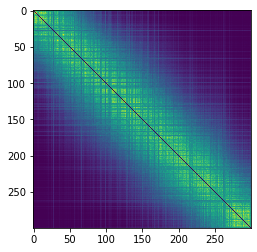

In [148]:
plt.imshow(W)

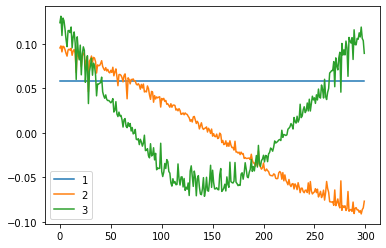

In [117]:
plt.plot(v[:,0], label = "1")
plt.plot(v[:,1], label = "2")
plt.plot(v[:,2], label = "3")
plt.legend()

In [118]:
scipy.stats.pearsonr(actual_time, v[:,1])

(-0.9936572761082583, 7.148787453085536e-285)

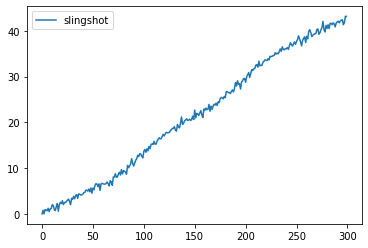

In [119]:
plt.plot(sling_pseudotime, label = "slingshot")
plt.legend()

In [120]:
scipy.stats.pearsonr(actual_time, sling_pseudotime)

(0.9972601055539106, 0.0)

slingshot pseudotime has better correlation with the actual time

## MST 

In [122]:
X = csr_matrix(euc_dist)
Tcsr = minimum_spanning_tree(X)

tcsr_arr = Tcsr.toarray() + Tcsr.toarray().T
tcsr_bool = (tcsr_arr > 0).astype(int)

row_sum = np.sum(tcsr_bool, axis = 1)
D_inv = np.diag(1/row_sum)
Tcsr_norm = D_inv @ tcsr_bool

lmbda, v = np.linalg.eig(Tcsr_norm)
sorted_idx = np.argsort(lmbda)[::-1]

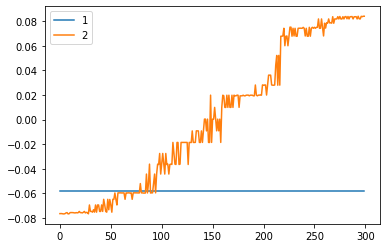

In [123]:
plt.plot(v[:,sorted_idx[0]], label = "1")
plt.plot(v[:,sorted_idx[1]], label = "2")
plt.legend()

In [124]:
scipy.stats.pearsonr(actual_time, v[:,sorted_idx[1]])

((0.9836844860635108+0j), 4.704281609577952e-224)

## MST using 1/similarity as the edge weight 

In [125]:
inv_sim = 1/affinity
X = csr_matrix(inv_sim)
Tcsr = minimum_spanning_tree(X)

tcsr_arr = Tcsr.toarray() + Tcsr.toarray().T
tcsr_bool = tcsr_arr > 0

row_sum = np.sum(tcsr_bool, axis = 1)
D_inv = np.diag(1/row_sum)
Tcsr_norm = D_inv @ tcsr_bool

lmbda, v = np.linalg.eig(Tcsr_norm)
sorted_idx = np.argsort(lmbda)[::-1]

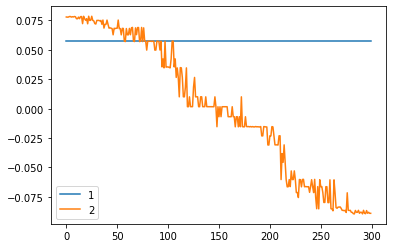

In [126]:
plt.plot(v[:,sorted_idx[0]], label = "1")
plt.plot(v[:,sorted_idx[1]], label = "2")
plt.legend()

In [127]:
scipy.stats.pearsonr(actual_time, v[:,sorted_idx[1]])

((-0.9842977792129965+0j), 1.6327342667896374e-226)

- 2nd eigenvector on MST has lower correlation with actual time compared with using the full graph. 
- higher correlation with actual time when using 1/similarity compared with Euclidean distance.

# Simulate single trajectory using python

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
x_early_deact = np.exp(np.arctan((np.arange(300, 0, -1) - 200)/50))
x_late_deact = np.exp(np.arctan((np.arange(300, 0, -1) - 100)/50))
x_early_act = np.exp(np.arctan((np.arange(1, 301) - 100)/50))
x_late_act = np.exp(np.arctan((np.arange(1, 301) - 200)/50))
x_transient = np.exp(np.arctan( np.hstack((np.arange(1, 101)/33, np.repeat(3,100), np.arange(100, 0, -1)/33))))

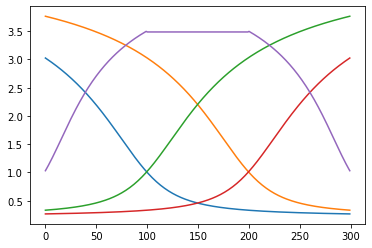

In [4]:
plt.plot(x_early_deact)
plt.plot(x_late_deact)
plt.plot(x_early_act)
plt.plot(x_late_act)
plt.plot(x_transient)

In [12]:
x_nonDE = np.repeat(np.array([0.1, 0.5, 1, 2, 3])[np.newaxis,], 300, axis = 0).T

means = np.vstack(
 (np.repeat(x_nonDE,100, axis = 0), # 500 non DE
  np.repeat(x_early_deact[np.newaxis,], 50, axis = 0), 
  np.repeat(x_late_deact[np.newaxis,], 50, axis = 0),
  np.repeat(x_early_act[np.newaxis,], 50, axis = 0), 
  np.repeat(x_late_act[np.newaxis,], 50, axis = 0),
  np.repeat(x_transient[np.newaxis,], 50, axis = 0)
 )
) # cells x gene
n_cell = means.shape[0]
row_sum = np.apply_along_axis(sum, arr = means, axis = 1)
D_inv = np.diag(1/row_sum)
means_norm = D_inv @ means

mu = 7500
size = 4
p = size/(size + mu)
n = mu * p / (1 - p)

total_counts = np.random.negative_binomial(n = n, p = p, size = 750)

gene_count = np.empty_like(means)
for i in range(n_cell):
    total_c = total_counts[i]
    prob_vec = means_norm[i,:]
    gene_count[i,] = np.random.multinomial(n = total_c, pvals = prob_vec)

In [19]:
gene_count.shape

(750, 300)

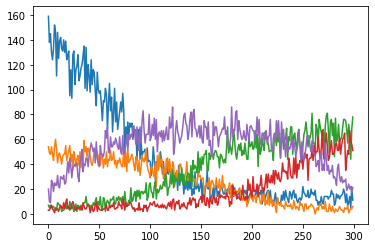

In [30]:
# plot  genes from each category
plt.plot(gene_count[500,:])
plt.plot(gene_count[550,:])
plt.plot(gene_count[600,:])
plt.plot(gene_count[650,:])
plt.plot(gene_count[700,:])

In [31]:
# used unnormalized data
euc_dist = compute_distances(gene_count.T)
affinity = compute_affinity_matrix(euc_dist, kernel_type = "adaptive", k = 15)
W = affinity - np.eye(300)

row_sum = np.sum(W, axis = 1)
D_inv = np.diag(1/row_sum)
Ms = D_inv @ W

# eigendecomposition of Ms
lmbda, v = np.linalg.eig(Ms)

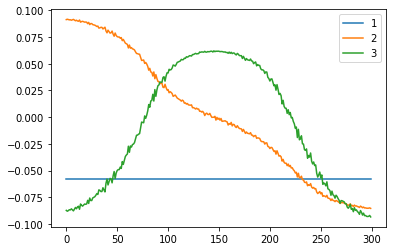

In [32]:
plt.plot(v[:,0], label = "1")
plt.plot(v[:,1], label = "2")
plt.plot(v[:,2], label = "3")
plt.legend()

# Simulate path from splatter

example code from Single Cell Machine Learning Workshop: https://colab.research.google.com/github/KrishnaswamyLab/SingleCellWorkshop/blob/master/exercises/TrajectoryInference/notebooks/00_Pseudotime_from_scratch.ipynb#scrollTo=SXDpvjfhT40U

## Example for path

In [10]:
n_groups = 2
cells_per_path = 100
params = {'method':'paths', 'batch_cells':cells_per_path * n_groups, 'seed':42, 
         'group_prob':np.tile(1/n_groups, n_groups), 'path_from':[0, 1], 'n_genes':500,
         'de_fac_loc':0.2}

results = scprep.run.SplatSimulate(**params)
data = pd.DataFrame(results['true_counts'])
metadata = pd.DataFrame({'step':results['step'], 'group':results['group']})
metadata = metadata.astype({'step': int})
new_index = pd.Index(['cell_{}'.format(i) for i in range(metadata.shape[0])])
data.index = new_index
metadata.index = new_index

# sort by step 
metadata.loc[metadata['group'] == 2,'step'] = metadata['step'][metadata['group'] == 2] + np.max(metadata['step'])
pseudotime = metadata['step']

idx = np.argsort(metadata['step'].values)
data = data.iloc[idx,:]
metadata = metadata.iloc[idx,:]

data_ln = scprep.normalize.library_size_normalize(data)

data_pca = scprep.reduce.pca(np.sqrt(data_ln), n_components = 20)
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(data_pca)

euc_dist = compute_distances(data_pca.values)
affinity = compute_affinity_matrix(euc_dist, kernel_type = "adaptive", k = 5)

W = affinity - np.eye(data.shape[0])
row_sum = np.sum(W, axis = 1)
D_inv = np.diag(1/row_sum)
Ms = D_inv @ W
lmbda, v = np.linalg.eig(Ms)

R[write to console]: Getting parameters...
R[write to console]: Creating simulation object...
R[write to console]: Simulating library sizes...
R[write to console]: Simulating gene means...
R[write to console]: Simulating path endpoints...
R[write to console]: Simulating path steps...
R[write to console]: Simulating BCV...
R[write to console]: Simulating counts...
R[write to console]: Simulating dropout (if needed)...
R[write to console]: Done!


Calculating PHATE...
  Running PHATE on 200 observations and 20 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.01 seconds.
  Calculating optimal t...
    Automatically selected t = 14
  Calculated optimal t in 0.02 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.03 seconds.
Calculated PHATE in 0.08 seconds.


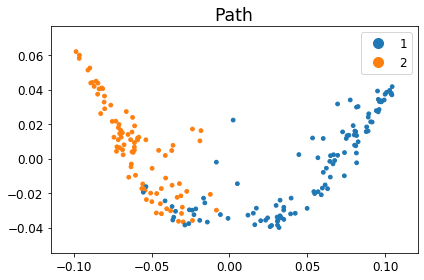

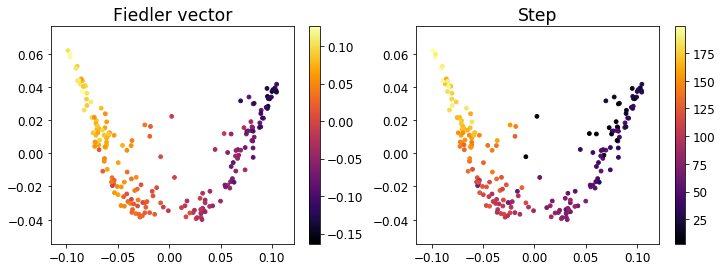

In [11]:
scprep.plot.scatter2d(data_phate, c=metadata['group'], legend_anchor=(1,1), title = "Path")
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
scprep.plot.scatter2d(data_phate, c=v[:,1], legend_anchor=(1,1), ax = ax[0], title = "Fiedler vector")
scprep.plot.scatter2d(data_phate, c=metadata['step'], legend_anchor=(1,1), ax = ax[1], title = "Step")
plt.show()

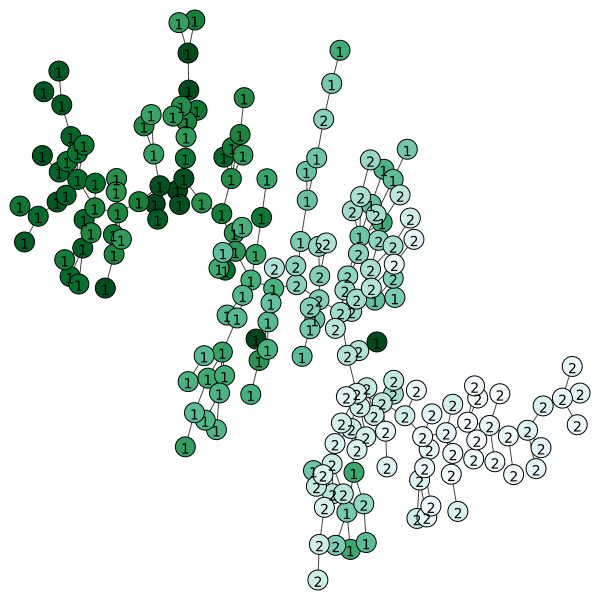

In [244]:
rgb_pal = sns.color_palette("BuGn_r", euc_dist.shape[0])

# MST with Euclidean distance

X = csr_matrix(euc_dist)
Tcsr = minimum_spanning_tree(X)
mst = igraph.Graph.Adjacency((Tcsr.toarray() > 0).tolist(), mode = igraph.ADJ_UNDIRECTED)
mst.es['weight'] = Tcsr.toarray()[Tcsr.toarray().nonzero()]
mst.vs['label'] =  metadata["group"]
mst.vs['color'] = rgb_pal

layout = mst.layout("kk")
igraph.plot(mst, layout = layout)

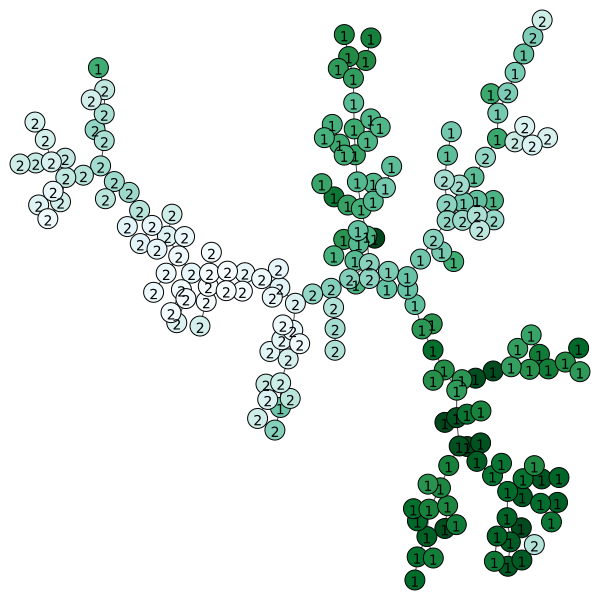

In [245]:
# MST with 1/similarity
inv_sim = 1/affinity
X = csr_matrix(inv_sim)
Tcsr = minimum_spanning_tree(X)

mst = igraph.Graph.Adjacency((Tcsr.toarray() > 1).tolist(), mode = igraph.ADJ_UNDIRECTED)
mst.es['weight'] = Tcsr.toarray()[Tcsr.toarray().nonzero()]
mst.vs['label'] =  metadata["group"]
mst.vs['color'] = rgb_pal

layout = mst.layout("kk")
igraph.plot(mst, layout = layout)

## Example for  1 bifurcation (3 paths)


In [52]:
import copy

In [53]:
idx2 = copy.deepcopy(metadata['step'])

In [54]:
np.max(metadata['step'])

200

In [64]:
n_groups = 3
cells_per_path = 100
params = {'method':'paths', 'batch_cells':cells_per_path * n_groups, 'seed':42, 
         'group_prob':np.tile(1/n_groups, n_groups), 'path_from':[0, 1, 1], 'n_genes':500,
         'de_fac_loc':0.2}

results = scprep.run.SplatSimulate(**params)
data = pd.DataFrame(results['true_counts'])
metadata = pd.DataFrame({'step':results['step'], 'group':results['group']})
metadata = metadata.astype({'step': int})
new_index = pd.Index(['cell_{}'.format(i) for i in range(metadata.shape[0])])
data.index = new_index
metadata.index = new_index

# sort by step 
max_step = np.max(metadata['step'])
metadata.loc[metadata['group'] == 2,'step'] = metadata['step'][metadata['group'] == 2] + max_step
metadata.loc[metadata['group'] == 3,'step'] = metadata['step'][metadata['group'] == 3] + max_step 
pseudotime = metadata['step']



idx = np.argsort(metadata['step'].values) #? sort by group then step
data = data.iloc[idx,:]
metadata = metadata.iloc[idx,:]

data_ln = scprep.normalize.library_size_normalize(data)

data_pca = scprep.reduce.pca(np.sqrt(data_ln), n_components = 20)
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(data_pca)

euc_dist = compute_distances(data_pca.values)
affinity = compute_affinity_matrix(euc_dist, kernel_type = "adaptive", k = 5)

W = affinity - np.eye(data.shape[0])
row_sum = np.sum(W, axis = 1)
D_inv = np.diag(1/row_sum)
Ms = D_inv @ W
lmbda, v = np.linalg.eig(Ms)

R[write to console]: Getting parameters...
R[write to console]: Creating simulation object...
R[write to console]: Simulating library sizes...
R[write to console]: Simulating gene means...
R[write to console]: Simulating path endpoints...
R[write to console]: Simulating path steps...
R[write to console]: Simulating BCV...
R[write to console]: Simulating counts...
R[write to console]: Simulating dropout (if needed)...
R[write to console]: Done!


Calculating PHATE...
  Running PHATE on 300 observations and 20 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 16
  Calculated optimal t in 0.03 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.06 seconds.
Calculated PHATE in 0.13 seconds.


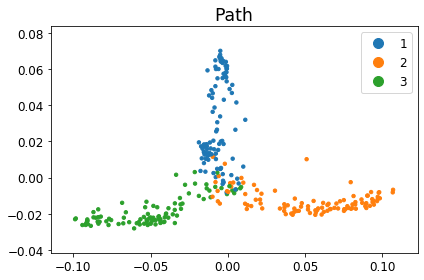

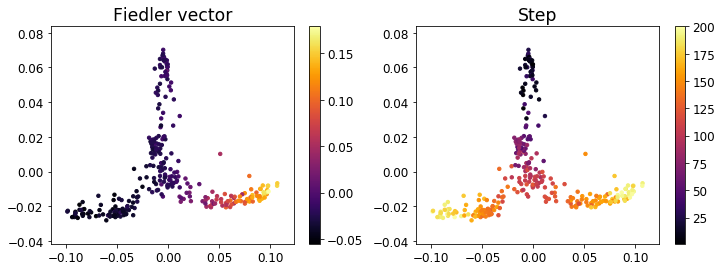

In [3]:
scprep.plot.scatter2d(data_phate, c=metadata['group'], legend_anchor=(1,1), title = "Path")
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
scprep.plot.scatter2d(data_phate, c=v[:,1], legend_anchor=(1,1), ax = ax[0], title = "Fiedler vector")
scprep.plot.scatter2d(data_phate, c=metadata['step'], legend_anchor=(1,1), ax = ax[1], title = "Step")
plt.show()

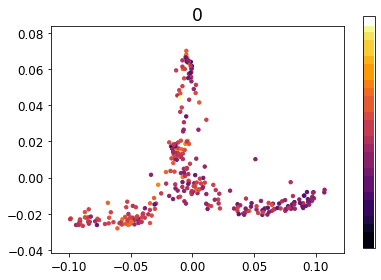

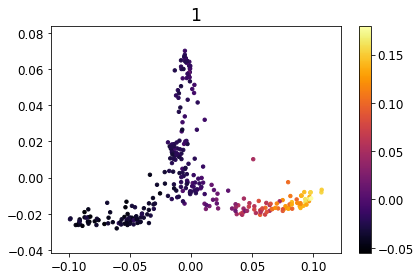

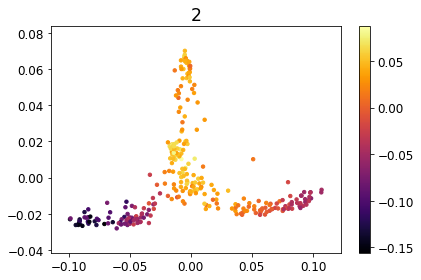

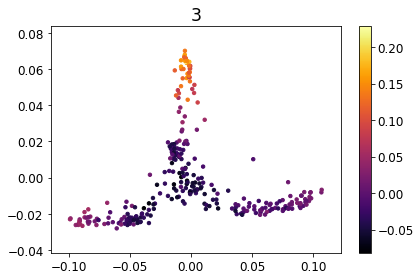

In [65]:
for i in range(4):
    scprep.plot.scatter2d(data_phate, c=v[:,i], legend_anchor=(1,1), title = str(i))

In [4]:
# ground truth adjacency
path = metadata['group']
ordering = metadata['step']

In [33]:
A = np.zeros((300, 300))

# F T F....
# T F T

In [11]:
np.sum(path == 1)

101

In [12]:
np.sum(path == 2)

102

In [13]:
np.sum(path == 3)

97

In [23]:
def diag_above_below(width):
    return np.diag(np.ones(width - 1), 1) + np.diag(np.ones(width - 1), -1)

In [34]:
path_1 = diag_above_below(101)
path_2 = diag_above_below(102)
path_3 = diag_above_below(97)

In [35]:
A[0:101, 0:101] = path_1

In [36]:
A[101:203, 101:203] = path_2

In [37]:
A[203:, 203:] = path_3

In [47]:
A[100,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [48]:
np.where(A[100,:] == 1)

(array([ 99, 101, 203]),)

In [39]:
A[100,101] = 1
A[101,100] = 1

In [41]:
A[100,203] = 1
A[203, 100] = 1

In [42]:
ground_truth_tree = igraph.Graph.Adjacency((A == 1).tolist(), mode = igraph.ADJ_UNDIRECTED)

In [43]:
ground_truth_tree.es['weight'] = A[A.nonzero()]

In [44]:
ground_truth_tree.vs['label'] =  metadata["group"] 
rgb_pal = sns.color_palette("BuGn_r", euc_dist.shape[0])[]
ground_truth_tree.vs['color'] = rgb_pal

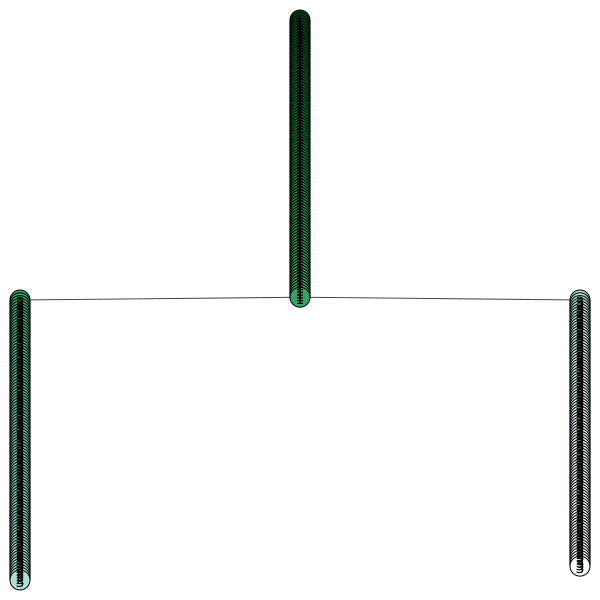

In [62]:
layout = ground_truth_tree.layout("rt", root = [0])
igraph.plot(ground_truth_tree, layout = layout)

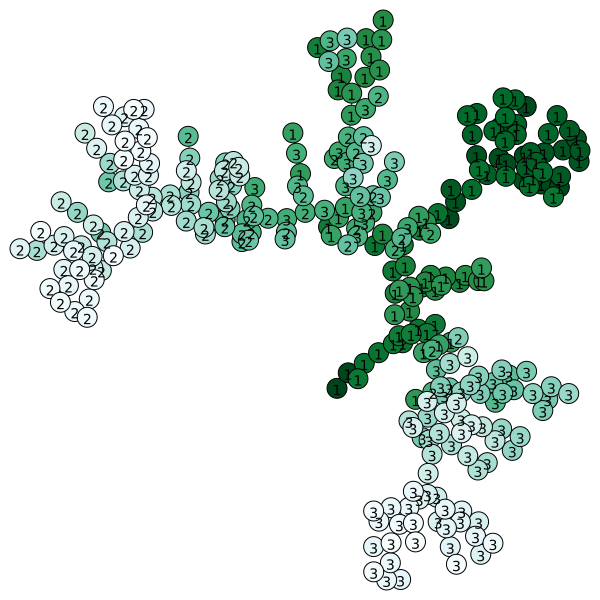

In [252]:
rgb_pal = sns.color_palette("BuGn_r", euc_dist.shape[0])

# MST with Euclidean distance

X = csr_matrix(euc_dist)
Tcsr = minimum_spanning_tree(X)
mst = igraph.Graph.Adjacency((Tcsr.toarray() > 0).tolist(), mode = igraph.ADJ_UNDIRECTED)
mst.es['weight'] = Tcsr.toarray()[Tcsr.toarray().nonzero()]
mst.vs['label'] =  metadata["group"] 
mst.vs['color'] = rgb_pal

layout = mst.layout("kk")
igraph.plot(mst, layout = layout)

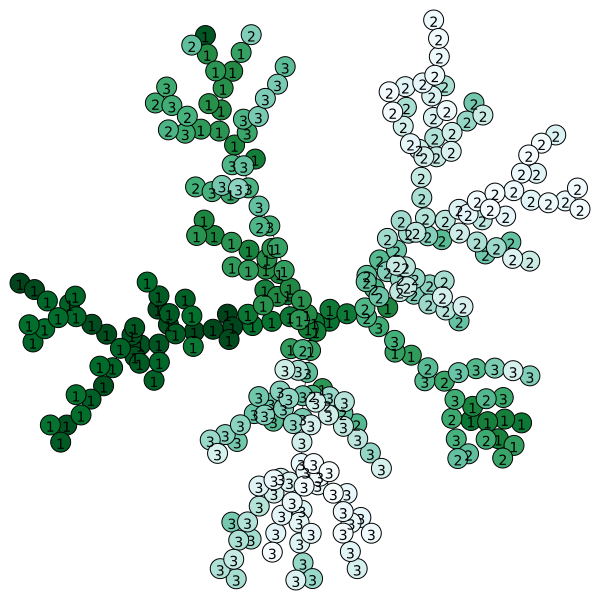

In [253]:
# MST with 1/similarity
inv_sim = 1/affinity
X = csr_matrix(inv_sim)
Tcsr = minimum_spanning_tree(X)

mst = igraph.Graph.Adjacency((Tcsr.toarray() > 1).tolist(), mode = igraph.ADJ_UNDIRECTED)
mst.es['weight'] = Tcsr.toarray()[Tcsr.toarray().nonzero()]
mst.vs['label'] =  metadata["group"]
mst.vs['color'] = rgb_pal

layout = mst.layout("kk")
igraph.plot(mst, layout = layout)

## Example for 2 bifurcations (5 paths)

In [256]:
n_groups = 5
cells_per_path = 100
params = {'method':'paths', 'batch_cells':cells_per_path * n_groups, 'seed':42, 
         'group_prob':np.tile(1/n_groups, n_groups), 'path_from':[0, 1, 1, 2, 2], 'n_genes':500,
         'de_fac_loc':0.2}

results = scprep.run.SplatSimulate(**params)
data = pd.DataFrame(results['true_counts'])
metadata = pd.DataFrame({'step':results['step'], 'group':results['group']})
metadata = metadata.astype({'step': int})
new_index = pd.Index(['cell_{}'.format(i) for i in range(metadata.shape[0])])
data.index = new_index
metadata.index = new_index

# sort by step 
max_step = np.max(metadata['step'])
metadata.loc[metadata['group'] == 2,'step'] = metadata['step'][metadata['group'] == 2] + max_step
metadata.loc[metadata['group'] == 3,'step'] = metadata['step'][metadata['group'] == 3] + max_step
metadata.loc[metadata['group'] == 4,'step'] = metadata['step'][metadata['group'] == 4] + max_step * 2
metadata.loc[metadata['group'] == 5,'step'] = metadata['step'][metadata['group'] == 5] + max_step * 2
pseudotime = metadata['step']

idx = np.argsort(metadata['step'].values)
data = data.iloc[idx,:]
metadata = metadata.iloc[idx,:]

data_ln = scprep.normalize.library_size_normalize(data)

data_pca = scprep.reduce.pca(np.sqrt(data_ln), n_components = 20)
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(data_pca)

euc_dist = compute_distances(data_pca.values)
affinity = compute_affinity_matrix(euc_dist, kernel_type = "adaptive", k = 5)

W = affinity - np.eye(data.shape[0])
row_sum = np.sum(W, axis = 1)
D_inv = np.diag(1/row_sum)
Ms = D_inv @ W
lmbda, v = np.linalg.eig(Ms)

R[write to console]: Getting parameters...
R[write to console]: Creating simulation object...
R[write to console]: Simulating library sizes...
R[write to console]: Simulating gene means...
R[write to console]: Simulating path endpoints...
R[write to console]: Simulating path steps...
R[write to console]: Simulating BCV...
R[write to console]: Simulating counts...
R[write to console]: Simulating dropout (if needed)...
R[write to console]: Done!


Calculating PHATE...
  Running PHATE on 500 observations and 20 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating optimal t...
    Automatically selected t = 17
  Calculated optimal t in 0.09 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.04 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.21 seconds.
Calculated PHATE in 0.39 seconds.


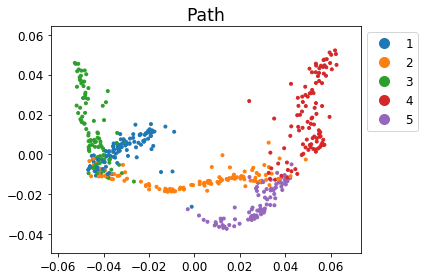

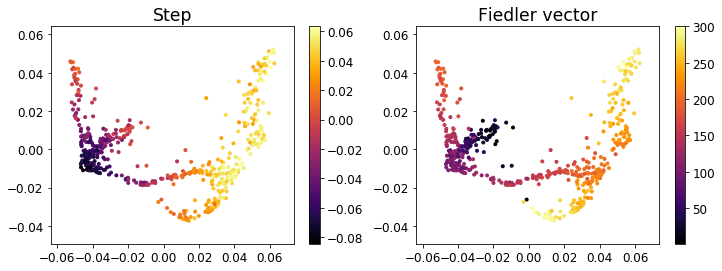

In [257]:
scprep.plot.scatter2d(data_phate, c=metadata['group'], legend_anchor=(1,1), title = "Path")
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
scprep.plot.scatter2d(data_phate, c=v[:,1], legend_anchor=(1,1), ax = ax[0], title = "Step")
scprep.plot.scatter2d(data_phate, c=metadata['step'], legend_anchor=(1,1), ax = ax[1], title = "Fiedler vector")
plt.show()

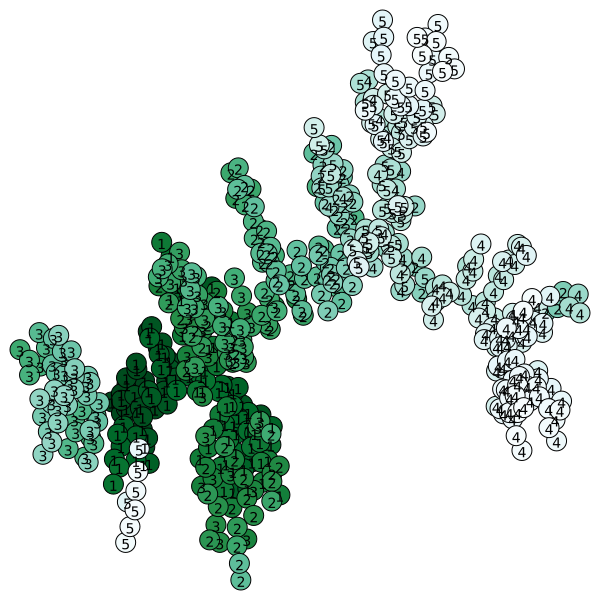

In [258]:
rgb_pal = sns.color_palette("BuGn_r", euc_dist.shape[0])

# MST with Euclidean distance

X = csr_matrix(euc_dist)
Tcsr = minimum_spanning_tree(X)
mst = igraph.Graph.Adjacency((Tcsr.toarray() > 0).tolist(), mode = igraph.ADJ_UNDIRECTED)
mst.es['weight'] = Tcsr.toarray()[Tcsr.toarray().nonzero()]
mst.vs['label'] =  metadata["group"] 
mst.vs['color'] = rgb_pal

layout = mst.layout("kk")
igraph.plot(mst, layout = layout)

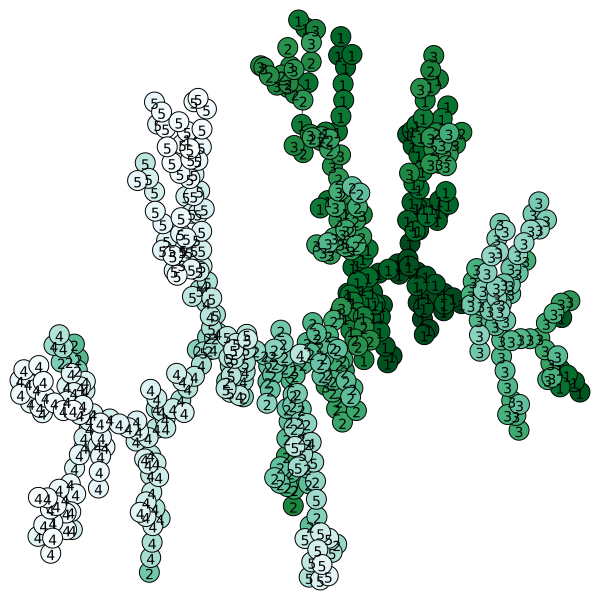

In [259]:
# MST with 1/similarity
inv_sim = 1/affinity
X = csr_matrix(inv_sim)
Tcsr = minimum_spanning_tree(X)

mst = igraph.Graph.Adjacency((Tcsr.toarray() > 1).tolist(), mode = igraph.ADJ_UNDIRECTED)
mst.es['weight'] = Tcsr.toarray()[Tcsr.toarray().nonzero()]
mst.vs['label'] =  metadata["group"]
mst.vs['color'] = rgb_pal

layout = mst.layout("kk")
igraph.plot(mst, layout = layout)